# Lips Reading
## Project for the course of Vision and Cognitive System at Univerisity of Padova

***
**Goal**: The aim of this project is to predict words or phrases from videos.
This task can be solved with both machine learning and deep learning techniques (for example, you can use a CNN to extract features from video frames and process extracted features with an RNN).
Pre-trained CNNs on human faces could improve classification results.
Data augmentation techniques should be applied to increase the number of samples.

**Authors**: Baldo Massimiliano, Bassan Davide, Panighel Cristiano.

## Introduction
This notebook contains all the code related part for the "lips reading" project.  
In order to run for yourself the notebook, make sure to have the appropiate enviroment and computing power.


In [39]:
import cv2
import dlib
import os
import numpy as np
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed, Input, Flatten, LSTM, Dropout, Dense, SimpleRNN, GRU
from keras.optimizer_v2.adam import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

## The Dataset

The choosen dataset is __[MIRACL-VC1](https://sites.google.com/site/achrafbenhamadou/-datasets/miracl-vc1)__ that contains frames labelled for words and sentences.

The words and sentences are stored using this structure:

![dataset structure](img/dataset-structure.png).

In [2]:
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
data_types = ['words']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']

## Mouth Detection

For this task we have tried two solutions, using __[OpenCV](https://opencv.org/)__ and using __[dlib](http://dlib.net/)__, two important libraries in Python for Computer Vision tasks.  
Both gives the possibility to use pre-trained models to recognize a mouth.

### Mouth detection using OpenCV

For the purpose of detecting mouth in a image using OpenCV, we relied on the **Haar Feature-based Cascade Classifiers**.  
You will find the necessary xml files whihc are used to load the model for detect first the face, and second the mouth inside a image.  
A detail guide is provided by the documentation of OpenCV at this __[link](https://docs.opencv.org/4.7.0/db/d28/tutorial_cascade_classifier.html)__.

In [3]:
def mouth_detection_cv(path):
    face_cascade = cv2.CascadeClassifier('preprocessing/cascade_files/haarcascade_frontalface_default.xml')
    mouth_cascade = cv2.CascadeClassifier('preprocessing/cascade_files/haarcascade_mcs_mouth.xml')

    if mouth_cascade.empty():
      raise IOError('Unable to load the mouth cascade classifier xml file')
    img = cv2.imread(path)
    face_rects = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=3)

    for(x,y,w,h) in face_rects:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
        roi = img[y:y+h, x:x+w]
        mouth_rects = mouth_cascade.detectMultiScale(roi, scaleFactor=1.1, minNeighbors=9)
        for(mx, my, mw, mh) in mouth_rects:
            my = int(my - 0.25*mh)
            roi_mouth = img[y+my:y+my+mh, x+mx:x+mx+mw]
            return roi_mouth

We have tried to tune the parameters of the function `detectMultiScale`, in particular `scaleFactor` and `minNeighbors`, but the shown values are the best found.

For the face recognition we haven't found so many problems, but for the mouth recognition the detection didn't work so well.  
We think the problem is due the size of the images.

### Mouth detection using dlib

In [4]:
def mouth_detection_dlib(path):
    face_detector = dlib.get_frontal_face_detector()

    p = "preprocessing/cascade_files/shape_predictor_68_face_landmarks.dat"

    lip_predictor = dlib.shape_predictor(p)
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_detector(gray)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        rect = dlib.rectangle(x, y, x + w, y + h)

        shape = lip_predictor(gray, rect)
        lip_points = []
        for i in range(48, 61):
            lip_points.append([shape.part(i).x, shape.part(i).y])

        x_min = int(min([p[0] for p in lip_points]))
        x_max = int(max([p[0] for p in lip_points]))
        y_min = int(min([p[1] for p in lip_points]))
        y_max = int(max([p[1] for p in lip_points]))

        lip_cropped = img[y_min:y_max, x_min:x_max]
        return lip_cropped

### dlib vs OpenCV
Just to give an idea of our assumption, this is the representation on the same image of the mouth detection using this two libraries.

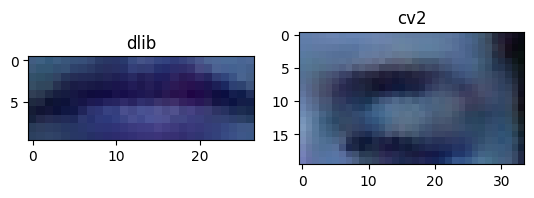

In [5]:
img_path = "MIRACL-VC1/F01/words/01/01/color_001.jpg"
roi_dlib = mouth_detection_dlib(img_path)
roi_cv2 = mouth_detection_cv(img_path)

plt.subplot(1,2,1)
plt.imshow(roi_dlib)
plt.title("dlib")
plt.subplot(1,2,2)
plt.imshow(roi_cv2)
plt.title("cv2")
plt.show()

#### Creation of Cropped Version of the Dataset
Once we have noted that OpenCV has less accuracy than dlib, we have chosen
to go on with dlib for creating a new version of each frame that includes only the mouth.

In [6]:
def crop_all():
    for person in tqdm(people, desc='Main', leave=True):
        for data_type in tqdm(data_types, desc='Type', leave=False):
            for enum in tqdm(folder_enum, desc='Label', leave=False):
                for instance in tqdm(instances, desc='Instance', leave=False):
                    path = "../MIRACL-VC1/" + person + "/" + data_type + "/" + enum + "/" + instance
                    images = os.listdir(path)
                    for image in tqdm(images, desc='Frame', leave=False):
                        if image.startswith('color'):
                            file_name = "../MIRACL-VC1/" + person + "/" + \
                                        str(data_type) + "/" + str(enum) + "/" + \
                                        str(instance) + "/" + "cropped_" + str(image)

                            cropped = mouth_detection_dlib(str(path + "/" + str(image)))
                            # UNCOMMENT ME
                            #cv2.imwrite(file_name, cropped)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> This statement can take a long time to execute
</div>

In [7]:
#crop_all()

## Splitting Test, Train and Validation set
At this point we have decided to split the dataset into Train, Validation and Test.  
Since the cropped images have different size, we have normalized and reshaped the image for our model.


In [8]:
def normalize_frames(frames, target_size):
    def resize_frames(x, size):
        res_frames = []
        for y in x:
            resized_frame = cv2.resize(y, size)
            res_frames.append(resized_frame)
        return res_frames

    resized_frames = resize_frames(frames, target_size)
    frames_normalized = preprocess_input(np.array(resized_frames))
    return frames_normalized

def one_hot_encode(output):
    one_hot = np.zeros((output.shape[0], 10))
    for i, label in enumerate(output):
        one_hot[i, label] = 1
    return one_hot

We have decided to divide the dataset **9/15 for training, 3/15 for validating and 3/15 for testing**.

In [9]:
max_seq_length = 22
test = ['M01', 'F11', 'F05']
validation = ['M02', 'F09', 'F10']

padding = [np.zeros((100, 100, 3))]

X_train_set = []
Y_train_set = []
X_test_set = []
Y_test_set = []
X_validation_set = []
Y_validation_set = []


for person in people:
    for data_type in data_types:
        for word_index, word in enumerate(folder_enum):
            for iteration in instances:
                path = "MIRACL-VC1/" + person + "/" + \
                       data_type + "/" + word + "/" + \
                       iteration
                file_list = sorted(os.listdir(path + "/"))
                sequence = []
                for file in file_list:
                    if file.startswith('cropped'):
                        img = cv2.imread(path + "/" + file)
                        sequence.append(img)

                sequence.extend(padding * (max_seq_length - len(sequence)))
                sequence = normalize_frames(sequence, (100,100))
                if person in validation:
                    X_validation_set.append(sequence)
                    Y_validation_set.append(word_index)
                if person in test:
                    X_test_set.append(sequence)
                    Y_test_set.append(word_index)
                else:
                    X_train_set.append(sequence)
                    Y_train_set.append(word_index)

Here there is an example of an image preprocessed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

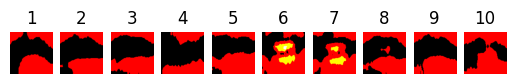

In [10]:
for i in range(1,11):
    plt.subplot(1,10,i)
    plt.imshow(X_train_set[0][i-1])
    plt.title(str(i))
    plt.axis('off')
plt.show()

### Data agumentation
Since our training set is not so big, we have chosen to apply some data agumentation technique in order to makes bigger our training set.  
To do so, we have created a generator function that automatize the transformation of the images.

In [11]:
def gen_data_agumentation(X, y, batch_size=32):
    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    while True:
        idxs = np.random.choice(len(X), batch_size, replace=False)
        X_batch = []
        Y_batch = []
        for idx in idxs:
            x_batch = X[idx]
            y_batch = y[idx]
            x_batch = np.array([datagen.random_transform(x) for x in x_batch])
            X_batch.append(x_batch)
            Y_batch.append(y_batch)
        yield np.array(X_batch), np.array(Y_batch)

## Architectures of the models
At this point, it was the moment to choose which type of achitecture use in other to solve the main problem.  
We have decided to use a CCN, specifically VGG16, combined with 3 types of RNN: a simple one, one with LSTM layers and one with GRU layers.  
In order to implement these model we used __[Keras](https://keras.io/)__, a framework for create and manipulate Deep Learining models.

### VGG16 + LSTM
This model is composed by a CNN, which is the VGG16, and the following additional layers:
1. **Input**:  
    This layer accepts an input with the shape input_shape.
2. **TimeDistributed**(VGG16):  
    This layer implements the CNN with a wrapper to temporize the data
    (since we have 22 frames and CNN accepts only an image).
3. **TimeDistributed**(Flatten):  
    This layer flattens all this 22 frames into an array of shape
    (batch_size*temporal_steps, height * width * channels).
4. **LSTM**(return_sequences=True):  
    This LSTM is able to manage temporized data.
5. **Dropout**(0.5):  
    This prevents overfitting, drops half of the values.
6. **LSTM**(0.5):  
    This LSTM returns a value of shape (batch_size * 128).
7. **Dropout**(0.5):  
    Same as point 5.
8. **Dense**:  
    Is a layer fully connected, uses a softmax activation function to
    make a probability distribution over all classes.

In [12]:
def build_model_LSTM(input_shape, num_classes):
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
  for layer in vgg16.layers:
    layer.trainable = False

  inputs = Input(shape=input_shape)
  x = TimeDistributed(vgg16)(inputs)
  x = TimeDistributed(Flatten())(x)
  x = LSTM(128, return_sequences=True)(x)
  x = Dropout(0.5)(x)
  x = LSTM(128)(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [13]:
model_LSTM = build_model_LSTM((22, 100, 100, 3), 10)
model_LSTM.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 22, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 22, 4608)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 22, 128)           2425344   
_________________________________________________________________
dropout (Dropout)            (None, 22, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

We have trained for 100 epochs using the Adam optimizer, with the default learning rate of 0.001.

In [14]:
gen_train = gen_data_agumentation(X_train_set, Y_train_set)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_LSTM = model_LSTM.fit(gen_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train_set) // 32,
    validation_data=(X_validation_set, Y_validation_set), validation_steps=len(X_validation_set) // 32,
    validation_batch_size=32, callbacks=[early_stopping])

In order to check if our model was overfitted we have plotted the history of the fit function

In [15]:
def plot_history(history, value_x, value_y, title=None, epochs=120, y_label=None, x_label=None, legend=None):
    # Plot training & validation loss values
    plt.plot(history.history[value_x])
    plt.plot(history.history[value_y])
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(1, epochs)
    # plt.ylim(0, 3)
    plt.legend(legend, loc='upper left')
    plt.show()

In [16]:
plot_history(history_LSTM, 'loss', 'val_loss', 'LSTM Model loss', 120, 'Loss', 'Epochs', ['Train', 'Validation'])

In [17]:
plot_history(history_LSTM, 'accuracy', 'val_accuracy', 'LSTM Model accuracy', 120, 'Accuracy', 'Epochs', ['Train', 'Validation'])

#### Train Performance
In order to see if the model generalize well we have plotted some metrics on the train set

In [32]:
y_pred = model_LSTM.predict(np.array(X_train_set))
y_pred_train_classes = np.argmax(y_pred,axis=1)

In [33]:
accuracy = accuracy_score(Y_train_set, y_pred_train_classes)
top5_accuracy = top_k_accuracy_score(Y_train_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_train_set, y_pred_train_classes)

Accuracy: 0.8391666666666666
Top-5 Accuracy: 0.9966666666666667


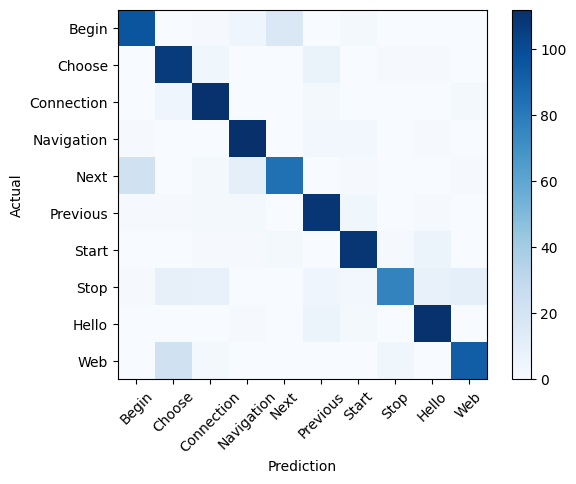

In [34]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#### Test Performance
And thus we have checked the results of the accuracy, the top-5 accuracy and the confusion matrix

In [18]:
y_pred = model_LSTM.predict(np.array(X_test_set))
y_pred_classes = np.argmax(y_pred,axis=1)

In [19]:
accuracy = accuracy_score(Y_test_set, y_pred_classes)
top5_accuracy = top_k_accuracy_score(Y_test_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_test_set, y_pred_classes)

Accuracy: 0.44
Top-5 Accuracy: 0.88


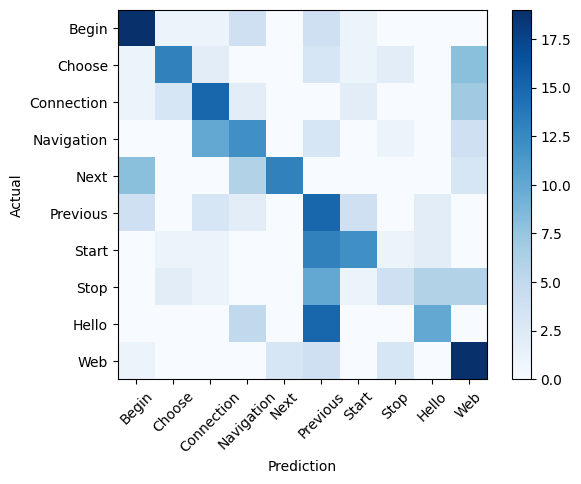

In [30]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

We have done the same for every further models.

### VGG16 + SimpleRNN
This model is composed by a CNN, which is the VGG16, and the following additional layers:
1. **Input**:  
    This layer accepts an input with the shape input_shape.
2. **TimeDistributed**(VGG16):  
    This layer implements the CNN with a wrapper to temporize the data
    (since we have 22 frames and CNN accepts only an image).
3. **TimeDistributed**(Flatten):  
    This layer flattens all this 22 frames into an array of shape
    (batch_size*temporal_steps, height * width * channels).
4. **SimpleRNN**(128, return_sequences=True):  
    Fully-connected RNN where the output is to be fed back to input.
5. **Dropout**(0.5):  
    This prevents overfitting, drops half of the values.
6. **SimpleRNN**(128):  
    Same as point 4.
7. **Dropout**(0.5):  
    Same as point 5.
8. **Dense**:  
    Is a layer fully connected, uses a softmax activation function to
    make a probability distribution over all classes.

In [35]:
def build_model_RNN(input_shape, num_classes):
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
  for layer in vgg16.layers:
    layer.trainable = False

  inputs = Input(shape=input_shape)
  x = TimeDistributed(vgg16)(inputs)
  x = TimeDistributed(Flatten())(x)
  x = SimpleRNN(128, return_sequences=True)(x)
  x = Dropout(0.5)(x)
  x = SimpleRNN(128)(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

  return model

In [36]:
model_RNN = build_model_RNN((22, 100, 100, 3), 10)
model_RNN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 22, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 22, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 22, 4608)          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 22, 128)           606336    
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

In [37]:
history_RNN = model_RNN.fit(gen_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train_set) // 32,
        validation_data=(X_validation_set, Y_validation_set), validation_steps=len(X_validation_set) // 32,
        validation_batch_size=32, callbacks=[early_stopping])

In [38]:
plot_history(history_RNN, 'loss', 'val_loss', 'RNN Model loss', 120, 'Loss', 'Epochs', ['Train', 'Validation'])

In [39]:
plot_history(history_RNN, 'accuracy', 'val_accuracy', 'RNN Model accuracy', 120, 'Accuracy', 'Epochs', ['Train', 'Validation'])

#### Train Performance

In [40]:
y_pred = model_RNN.predict(np.array(X_train_set))
y_pred_train_classes = np.argmax(y_pred,axis=1)

In [41]:
accuracy = accuracy_score(Y_train_set, y_pred_train_classes)
top5_accuracy = top_k_accuracy_score(Y_train_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_train_set, y_pred_train_classes)

Accuracy: 0.1025
Top-5 Accuracy: 0.5033333333333333


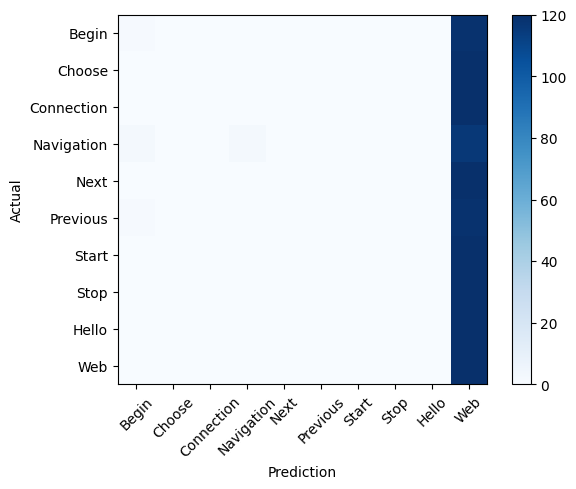

In [42]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#### Test Performance

In [43]:
y_pred = model_RNN.predict(np.array(X_test_set))
y_pred_classes = np.argmax(y_pred,axis=1)

In [44]:
accuracy = accuracy_score(Y_test_set, y_pred_classes)
top5_accuracy = top_k_accuracy_score(Y_test_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_test_set, y_pred_classes)

Accuracy: 0.1
Top-5 Accuracy: 0.5033333333333333


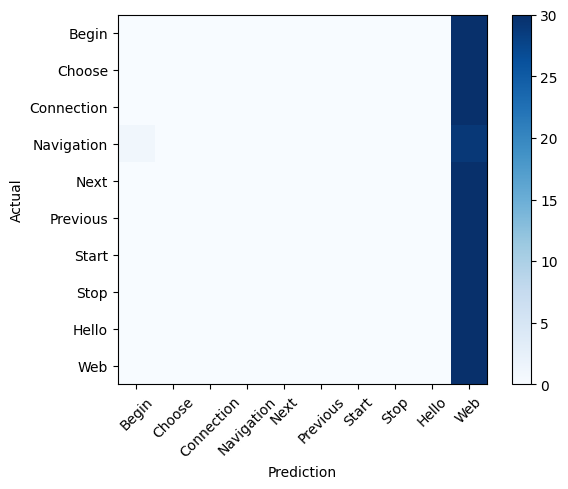

In [45]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

### VGG16 + GRU
This model is composed by a CNN, which is the VGG16, and the following additional layers:
1. **Input**:  
    This layer accepts an input with the shape input_shape.
2. **TimeDistributed**(VGG16):  
    This layer implements the CNN with a wrapper to temporize the data
    (since we have 22 frames and CNN accepts only an image).
3. **TimeDistributed**(Flatten):  
    This layer flattens all this 22 frames into an array of shape
    (batch_size*temporal_steps, height * width * channels).
4. **GRU**(128, return_sequences=True):  
    Layer that implement the Gated Recurrent Unit.
5. **Dropout**(0.5):  
    This prevents overfitting, drops half of the values.
6. **GRU**(128):  
    Same as point 4.
7. **Dropout**(0.5):  
    Same as point 5.
8. **Dense**:  
    Is a layer fully connected, uses a softmax activation function to
    make a probability distribution over all classes.

In [12]:
def build_model_GRU(input_shape, num_classes):
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
  for layer in vgg16.layers:
    layer.trainable = False

  inputs = Input(shape=input_shape)
  x = TimeDistributed(vgg16)(inputs)
  x = TimeDistributed(Flatten())(x)
  x = GRU(128, return_sequences=True)(x)
  x = Dropout(0.5)(x)
  x = GRU(128)(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

  return model

In [13]:
model_GRU = build_model_GRU((22, 100, 100, 3), 10)
model_GRU.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 22, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 22, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_11 (TimeDis (None, 22, 4608)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 22, 128)           1819392   
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0   

In [14]:
history_GRU = model_GRU.fit(gen_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train_set) // 32,
        validation_data=(X_validation_set, Y_validation_set), validation_steps=len(X_validation_set) // 32,
        validation_batch_size=32, callbacks=[early_stopping])

In [15]:
plot_history(history_GRU, 'loss', 'val_loss', 'GRU Model loss', 120, 'Loss', 'Epochs', ['Train', 'Validation'])

In [16]:
plot_history(history_GRU, 'accuracy', 'val_accuracy', 'GRU Model accuracy', 120, 'Accuracy', 'Epochs', ['Train', 'Validation'])

#### Train Performance

In [17]:
y_pred = model_GRU.predict(np.array(X_train_set))
y_pred_train_classes = np.argmax(y_pred,axis=1)

In [18]:
accuracy = accuracy_score(Y_train_set, y_pred_train_classes)
top5_accuracy = top_k_accuracy_score(Y_train_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_train_set, y_pred_train_classes)

Accuracy: 0.9183333333333333
Top-5 Accuracy: 0.9991666666666666


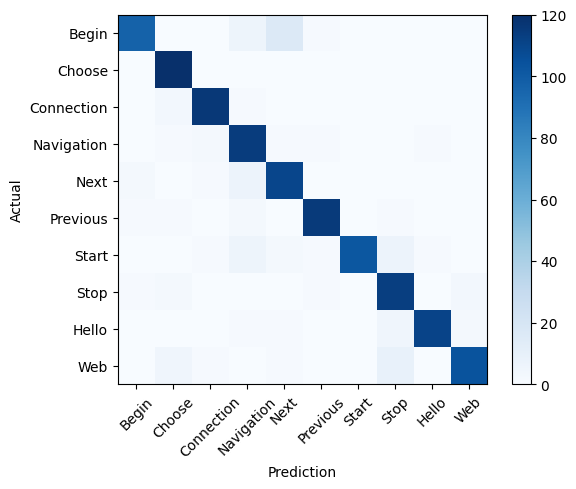

In [19]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#### Test Performance

In [20]:
y_pred = model_GRU.predict(np.array(X_test_set))
y_pred_classes = np.argmax(y_pred,axis=1)

In [21]:
accuracy = accuracy_score(Y_test_set, y_pred_classes)
top5_accuracy = top_k_accuracy_score(Y_test_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_test_set, y_pred_classes)

Accuracy: 0.48333333333333334
Top-5 Accuracy: 0.9133333333333333


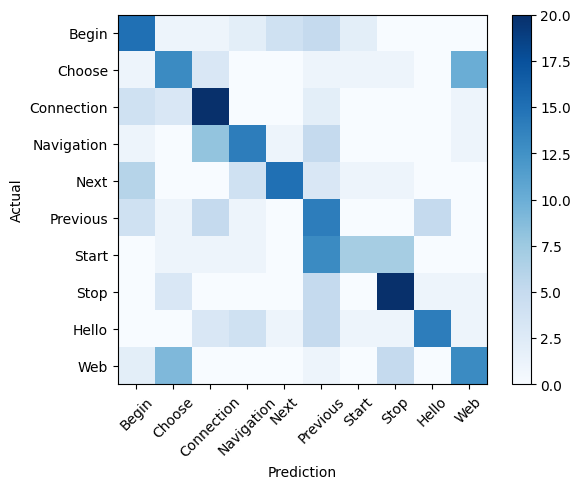

In [22]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

## Further Investigation
Trying to improve the results, we held the best RNN model (which was GRU) and decided to to change the underlying CNN, with __[MobileNet](https://arxiv.org/abs/1704.04861)__ and __[ResNet](https://en.wikipedia.org/wiki/Residual_neural_network)__.

### MobileNet

In [23]:
def build_model_GRU_MN(input_shape, num_classes):
    mobile_net = MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    for layer in mobile_net.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = TimeDistributed(mobile_net)(inputs)
    x = TimeDistributed(Flatten())(x)
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = GRU(128)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [24]:
model_GRU_MN = build_model_GRU_MN((22, 100, 100, 3), 10)
model_GRU_MN.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 22, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 22, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_11 (TimeDis (None, 22, 4608)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 22, 128)           1819392   
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0   

In [25]:
history_GRU_MN = model_GRU_MN.fit(gen_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train_set) // 32,
        validation_data=(X_validation_set, Y_validation_set), validation_steps=len(X_validation_set) // 32,
        validation_batch_size=32, callbacks=[early_stopping])

In [27]:
plot_history(history_GRU_MN, 'loss', 'val_loss', 'GRU_MN Model loss', 120, 'Loss', 'Epochs', ['Train', 'Validation'])

In [26]:
plot_history(history_GRU_MN, 'accuracy', 'val_accuracy', 'GRU_MN Model accuracy', 120, 'Accuracy', 'Epochs', ['Train', 'Validation'])

#### Train Performance

In [28]:
y_pred = model_GRU_MN.predict(np.array(X_train_set))
y_pred_train_classes = np.argmax(y_pred,axis=1)

In [29]:
accuracy = accuracy_score(Y_train_set, y_pred_train_classes)
top5_accuracy = top_k_accuracy_score(Y_train_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_train_set, y_pred_train_classes)

Accuracy: 0.4708333333333333
Top-5 Accuracy: 0.9216666666666666


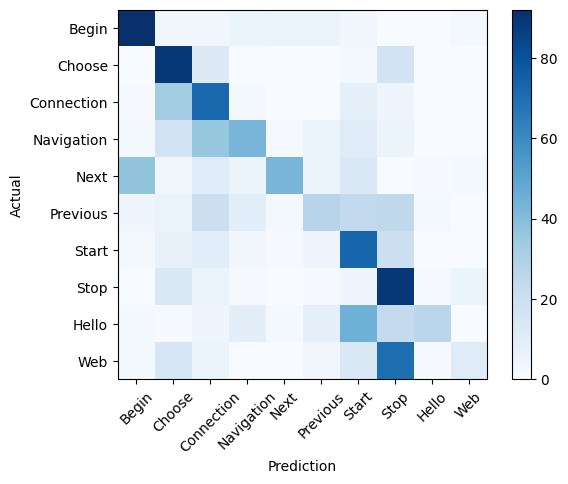

In [30]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#### Test Performance

In [31]:
y_pred = model_GRU_MN.predict(np.array(X_test_set))
y_pred_classes = np.argmax(y_pred,axis=1)

In [32]:
accuracy = accuracy_score(Y_test_set, y_pred_classes)
top5_accuracy = top_k_accuracy_score(Y_test_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_test_set, y_pred_classes)

Accuracy: 0.17333333333333334
Top-5 Accuracy: 0.7133333333333334


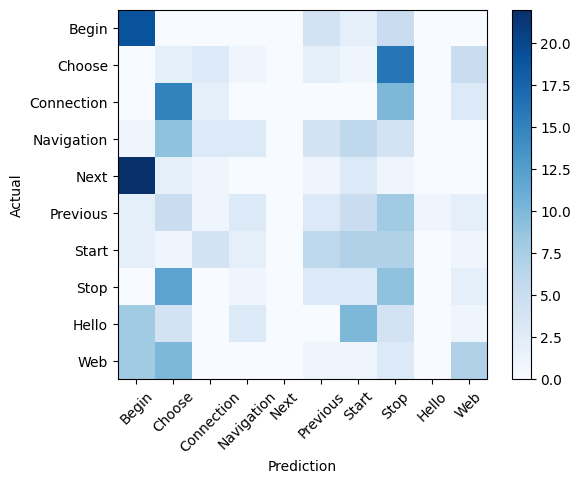

In [33]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

### ResNet

In [40]:
def build_model_GRU_RN(input_shape, num_classes):
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    for layer in resnet.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = TimeDistributed(resnet)(inputs)
    x = TimeDistributed(Flatten())(x)
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = GRU(128)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [41]:
model_GRU_RN = build_model_GRU_RN((22, 100, 100, 3), 10)
model_GRU_RN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 22, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 22, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_8 (TimeDist (None, 22, 32768)         0         
_________________________________________________________________
gru_6 (GRU)                  (None, 22, 128)           12632832  
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0   

In [42]:
history_GRU_RN = model_GRU_MN.fit(gen_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train_set) // 32,
        validation_data=(X_validation_set, Y_validation_set), validation_steps=len(X_validation_set) // 32,
        validation_batch_size=32, callbacks=[early_stopping])

In [43]:
plot_history(history_GRU_RN, 'loss', 'val_loss', 'GRU_RN Model loss', 120, 'Loss', 'Epochs', ['Train', 'Validation'])

In [44]:
plot_history(history_GRU_RN, 'accuracy', 'val_accuracy', 'GRU_RN Model accuracy', 120, 'Accuracy', 'Epochs', ['Train', 'Validation'])

#### Train Performance

In [45]:
y_pred = model_GRU_RN.predict(np.array(X_train_set))
y_pred_train_classes = np.argmax(y_pred,axis=1)

In [46]:
accuracy = accuracy_score(Y_train_set, y_pred_train_classes)
top5_accuracy = top_k_accuracy_score(Y_train_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_train_set, y_pred_train_classes)

Accuracy: 0.8483333333333334
Top-5 Accuracy: 0.9991666666666666


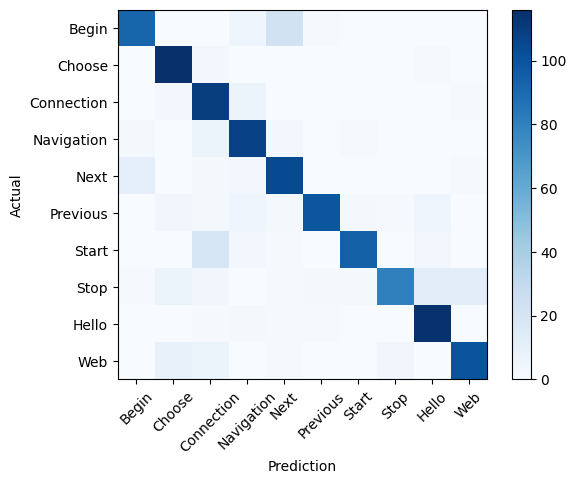

In [47]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#### Test Performance

In [48]:
y_pred = model_GRU_RN.predict(np.array(X_test_set))
y_pred_classes = np.argmax(y_pred,axis=1)

In [49]:
accuracy = accuracy_score(Y_test_set, y_pred_classes)
top5_accuracy = top_k_accuracy_score(Y_test_set, y_pred, k=5)
confusion_matr = confusion_matrix(Y_test_set, y_pred_classes)

Accuracy: 0.58
Top-5 Accuracy: 0.9566666666666667


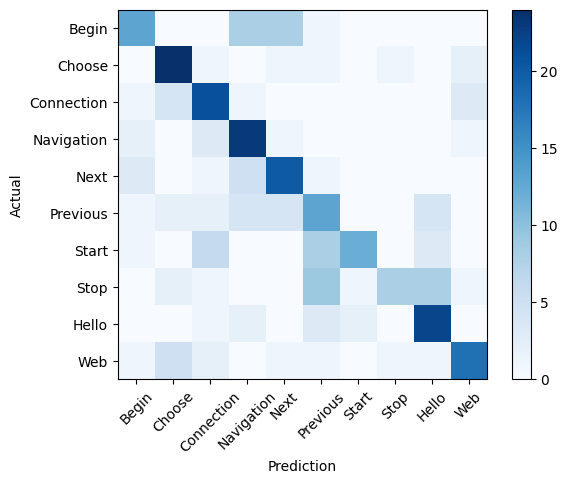

In [50]:
print('Accuracy: ' + str(accuracy))
print('Top-5 Accuracy: ' + str(top5_accuracy))
plt.imshow(confusion_matr, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()